In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import joblib

In [43]:
df = pd.read_csv("players_20.csv", on_bad_lines='skip')
print("Dataset loaded successfully.")
print("Number of rows:", len(df))
print("\nSample data:\n", df.head())

Dataset loaded successfully.
Number of rows: 18278

Sample data:
    sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2     190871  https://sofifa.com/player/190871/neymar-da-sil...   
3     200389  https://sofifa.com/player/200389/jan-oblak/20/...   
4     183277  https://sofifa.com/player/183277/eden-hazard/2...   

          short_name                            long_name  age         dob  \
0           L. Messi       Lionel Andrés Messi Cuccittini   32  1987-06-24   
1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   34  1985-02-05   
2          Neymar Jr        Neymar da Silva Santos Junior   27  1992-02-05   
3           J. Oblak                            Jan Oblak   26  1993-01-07   
4          E. Hazard                          Eden Hazard   28  1991-01-07   

   height_cm  weight_kg nationality                 club  ... 

In [44]:
features = [
    'age', 'weight_kg', 'potential',
    'skill_moves', 'work_rate', 'body_type',
    'pace', 'shooting', 'passing', 'defending',
    'physic', 'player_traits'
]

target = 'overall'
X = df[features]
y = df[target]

In [45]:
numerical_cols = ['age', 'weight_kg', 'potential', 'skill_moves', 'pace', 'shooting', 'passing', 'defending', 'physic']
categorical_cols = ['work_rate', 'body_type', 'player_traits']

# Clean numerical columns
for col in numerical_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(X[col].mean())

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = X[col].fillna('Unknown_Category').astype(str)
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

print("Data cleaned and encoded successfully.")


Data cleaned and encoded successfully.


/tmp/ipython-input-2445936941.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce').fillna(X[col].mean())
/tmp/ipython-input-2445936941.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna('Unknown_Category').astype(str)
/tmp/ipython-input-2445936941.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [46]:
skill_cols = ['pace', 'shooting', 'passing', 'defending', 'physic', 'potential']
target_col = 'overall'

df_calc = df[skill_cols + [target_col]].apply(pd.to_numeric, errors='coerce').dropna()

# Compute correlations and weights
correlations = df_calc[skill_cols].corrwith(df_calc[target_col])
weights = correlations.abs()
weights = weights / weights.sum()

weights_df = pd.DataFrame({
    'Correlation_with_Overall': correlations.round(3),
    'Normalized_Weight': weights.round(3)
}).sort_values('Normalized_Weight', ascending=False)

print("\n📊 Data-Driven Weights for Each Attribute:")
print(weights_df)

# Calculate overall using the weighted formula
df_calc['overall_calculated'] = 0
for col in skill_cols:
    df_calc['overall_calculated'] += df_calc[col] * weights[col]

df_calc['overall_calculated'] = (df_calc['overall_calculated'] / weights.sum()).round(1)

# Validate formula performance
r2 = r2_score(df_calc['overall'], df_calc['overall_calculated'])
mae = mean_absolute_error(df_calc['overall'], df_calc['overall_calculated'])

print("\n✅ Formula Validation Results:")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")

# Print derived formula
print("\n🧾 Derived Overall Formula:")
formula_str = " + ".join([f"({round(weights[col],3)} × {col})" for col in skill_cols])
print(f"Overall ≈ {formula_str}")



📊 Data-Driven Weights for Each Attribute:
           Correlation_with_Overall  Normalized_Weight
passing                       0.684              0.242
potential                     0.636              0.225
physic                        0.517              0.183
shooting                      0.498              0.176
defending                     0.335              0.118
pace                          0.159              0.056

✅ Formula Validation Results:
R² Score: 0.104
Mean Absolute Error: 5.580

🧾 Derived Overall Formula:
Overall ≈ (0.056 × pace) + (0.176 × shooting) + (0.242 × passing) + (0.118 × defending) + (0.183 × physic) + (0.225 × potential)


In [47]:
# ===========================================
# 🧮 CALCULATE 'overall_calculated' FOR ALL PLAYERS
# ===========================================

# Ensure skill attributes used in the formula match training ones
skill_cols = ['pace', 'shooting', 'passing', 'defending', 'physic', 'potential']

# Calculate the overall for each player based on the formula
df['overall_calculated'] = 0  # Initialize the column to store calculated values

for index, row in df.iterrows():
    overall_calc = 0
    for col in skill_cols:
        overall_calc += row[col] * weights[col]  # Using weights derived earlier
    df.at[index, 'overall_calculated'] = overall_calc / weights.sum()  # Normalize and store the result

# Round for consistency
df['overall_calculated'] = df['overall_calculated'].round(1)

# Display first 10 players for comparison
print("\nComparison of Actual vs Calculated Overall (Top 10 Players):")
print(df[['pace', 'shooting', 'passing', 'defending', 'physic', 'potential', 'overall', 'overall_calculated']].head(10))

/tmp/ipython-input-2112027213.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '81.14219936619307' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'overall_calculated'] = overall_calc / weights.sum()  # Normalize and store the result



Comparison of Actual vs Calculated Overall (Top 10 Players):
   pace  shooting  passing  defending  physic  potential  overall  \
0  87.0      92.0     92.0       39.0    66.0         94       94   
1  90.0      93.0     82.0       35.0    78.0         93       93   
2  91.0      85.0     87.0       32.0    58.0         92       92   
3   NaN       NaN      NaN        NaN     NaN         93       91   
4  91.0      83.0     86.0       35.0    66.0         91       91   
5  76.0      86.0     92.0       61.0    78.0         91       91   
6   NaN       NaN      NaN        NaN     NaN         93       90   
7  77.0      60.0     70.0       90.0    86.0         91       90   
8  74.0      76.0     89.0       72.0    66.0         90       90   
9  93.0      86.0     81.0       45.0    74.0         90       90   

   overall_calculated  
0                81.1  
1                80.6  
2                76.2  
3                 NaN  
4                77.2  
5                83.6  
6         

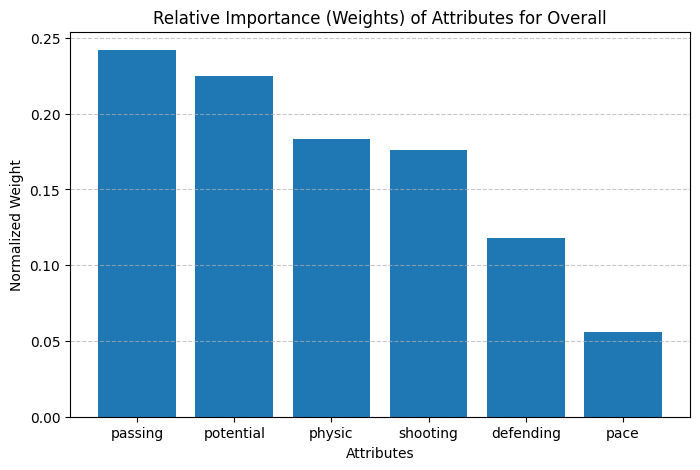

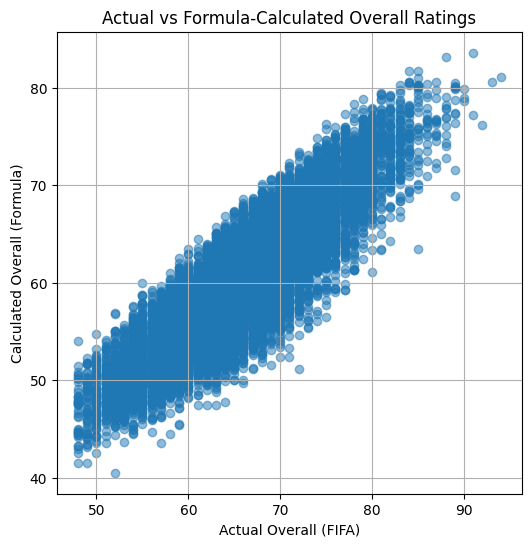

In [48]:
plt.figure(figsize=(8,5))
plt.bar(weights_df.index, weights_df['Normalized_Weight'])
plt.title("Relative Importance (Weights) of Attributes for Overall")
plt.xlabel("Attributes")
plt.ylabel("Normalized Weight")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df_calc['overall'], df_calc['overall_calculated'], alpha=0.5)
plt.title("Actual vs Formula-Calculated Overall Ratings")
plt.xlabel("Actual Overall (FIFA)")
plt.ylabel("Calculated Overall (Formula)")
plt.grid(True)
plt.show()


In [49]:
# ===========================================
# 🧮 CREATE ELIGIBILITY BASED ON 'overall_calculated'
# ===========================================

# Create eligibility column (1 = Eligible, 0 = Not Eligible)
df['eligible'] = (df['overall_calculated'] > 70).astype(int)

# Display first few entries to verify
print("\nEligibility Based on Calculated Overall (First 10 Players):")
print(df[['overall_calculated', 'eligible']].head(10))


Eligibility Based on Calculated Overall (First 10 Players):
   overall_calculated  eligible
0                81.1         1
1                80.6         1
2                76.2         1
3                 NaN         0
4                77.2         1
5                83.6         1
6                 NaN         0
7                78.6         1
8                79.9         1
9                79.0         1


In [50]:
# ===========================================
# 🧑‍🏫 SPLIT DATA AND TRAIN MODEL USING NEW 'eligible' LABEL
# ===========================================

# Features and Target
features = ['age', 'weight_kg', 'potential', 'skill_moves', 'work_rate', 'body_type',
            'pace', 'shooting', 'passing', 'defending', 'physic', 'player_traits']
target = 'eligible'

# Preparing data
X = df[features].copy() # Create a copy to avoid SettingWithCopyWarning
y = df[target]

# Encode categorical columns
# Re-apply the same encoding as before to handle categorical features for model training
for col in categorical_cols:
    le = label_encoders[col]
    X[col] = X[col].fillna('Unknown_Category').astype(str)
    X[col] = le.transform(X[col])


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForest model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set and evaluate
y_pred = model.predict(X_test)
print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.986870897155361

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3391
           1       0.97      0.84      0.90       265

    accuracy                           0.99      3656
   macro avg       0.98      0.92      0.95      3656
weighted avg       0.99      0.99      0.99      3656



In [51]:
new_player = {
    'age': 20,
    'weight_kg': 69,
    'potential': 42,
    'skill_moves': 3,
    'work_rate': 'Low/High',
    'body_type': 'Fat',
    'pace': 90,
    'shooting': 88,
    'passing': 85,
    'defending': 72,
    'physic': 74,
    'player_traits': 'Outside Foot Shot'
}

new_df = pd.DataFrame([new_player])

# Preprocess new player data
for col in numerical_cols:
    new_df[col] = pd.to_numeric(new_df[col], errors='coerce').fillna(X[col].mean())

for col in categorical_cols:
    le = label_encoders[col]
    new_df[col] = new_df[col].apply(lambda x: x if x in le.classes_ else 'Unknown_Category')
    if 'Unknown_Category' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'Unknown_Category')
    new_df[col] = le.transform(new_df[col])

# Predict eligibility
prediction = model.predict(new_df)[0]
print("\n🧍 NEW PLAYER PREDICTION:")
print("✅ Player is Eligible to Play" if prediction == 1 else "❌ Player is Not Eligible to Play")



🧍 NEW PLAYER PREDICTION:
✅ Player is Eligible to Play


In [52]:
# This code block outlines the logic for processing queries within your API endpoint.
# You would typically integrate this into a web framework like Flask or FastAPI.

import joblib
import pandas as pd
import numpy as np

# Assume model and label_encoders are loaded as described in the plan
# model = joblib.load('model.pkl')
# label_encoders = joblib.load('vectorizer.pkl')

# Define the expected features for the model
model_features = ['age', 'weight_kg', 'potential', 'skill_moves', 'work_rate', 'body_type',
                  'pace', 'shooting', 'passing', 'defending', 'physic', 'player_traits']

# Define numerical and categorical columns as used during training
numerical_cols = ['age', 'weight_kg', 'potential', 'skill_moves', 'pace', 'shooting', 'passing', 'defending', 'physic']
categorical_cols = ['work_rate', 'body_type', 'player_traits']

def process_query(query_text):
    """
    Processes a natural language query to determine player eligibility.

    Args:
        query_text (str): The user's natural language query.

    Returns:
        str: A natural language response about player eligibility or an
             out-of-domain message.
    """
    # --- Step 1: Attempt to extract player attributes from the query ---
    # This is a simplified example. A real implementation would require
    # more sophisticated natural language processing (NLP) to extract
    # entities like age, weight, pace, etc.
    # For demonstration, we'll assume the query contains key-value pairs
    # or you have another method to get the attributes.
    # Example: "Check eligibility for a player with age 25, pace 80, and shooting 75"

    # Placeholder for extracted attributes
    extracted_attributes = {}
    query_lower = query_text.lower()

    # Simple keyword matching (replace with more robust NLP)
    if "age" in query_lower:
        # In a real scenario, extract the number following "age"
        extracted_attributes['age'] = None # Placeholder
    if "pace" in query_lower:
         # In a real scenario, extract the number following "pace"
        extracted_attributes['pace'] = None # Placeholder
    # Add similar logic for other relevant attributes

    # --- Step 2: Check if sufficient domain-specific attributes were extracted ---
    # This is a heuristic. You might need a minimum number of key attributes.
    if not extracted_attributes or len(extracted_attributes) < 3: # Example threshold
        return "I can only answer questions about player eligibility based on their attributes (like age, pace, shooting, etc.). Please provide more details."

    # --- Step 3: Prepare data for the model ---
    # Create a DataFrame for the new player based on extracted attributes
    new_player_data = {feature: None for feature in model_features} # Initialize with None
    new_player_data.update(extracted_attributes) # Update with extracted values
    new_df = pd.DataFrame([new_player_data])

    # Preprocess the new player data using the same steps as training
    for col in numerical_cols:
        # In a real API, handle missing numerical values appropriately (e.g., mean from training data)
        new_df[col] = pd.to_numeric(new_df[col], errors='coerce').fillna(0) # Using 0 as a simple fallback


    for col in categorical_cols:
        # In a real API, handle missing categorical values and unknown categories
        new_df[col] = new_df[col].fillna('Unknown_Category').astype(str)
        if col in label_encoders:
             # Handle categories not seen during training gracefully
            new_df[col] = new_df[col].apply(lambda x: x if x in label_encoders[col].classes_ else 'Unknown_Category')
            # If 'Unknown_Category' wasn't in training classes, add it temporarily for transformation
            if 'Unknown_Category' not in label_encoders[col].classes_:
                 label_encoders[col].classes_ = np.append(label_encoders[col].classes_, 'Unknown_Category')
            new_df[col] = label_encoders[col].transform(new_df[col])
        else:
            # Handle case where label encoder is missing for a column
             new_df[col] = 0 # Or another appropriate fallback


    # Ensure the columns are in the same order as the training data
    new_df = new_df[model_features]


    # --- Step 4: Make a prediction using the loaded model ---
    try:
        prediction = model.predict(new_df)[0]
        # --- Step 5: Format the response ---
        if prediction == 1:
            response = "Based on the attributes provided, the player is likely eligible."
        else:
            response = "Based on the attributes provided, the player is likely not eligible."
    except Exception as e:
        print(f"Error during prediction: {e}")
        response = "An error occurred while processing your request."


    return response

# Example usage (in your API, this would be triggered by an incoming request)
# print(process_query("Check eligibility for a player with age 25, pace 80, and shooting 75"))
# print(process_query("What is the weather today?"))

In [53]:
# ===========================================
# 🧮 CALCULATE OVERALL FOR NEW PLAYER USING FORMULA
# ===========================================

# Ensure skill attributes used in formula match training ones
skill_cols = ['pace', 'shooting', 'passing', 'defending', 'physic', 'potential']

# Use the same weights you derived earlier
print("\n⚙️ Using weights derived from correlation:\n")
print(weights.round(3))

# Compute the formula-based overall for the new player
overall_calc = 0
for col in skill_cols:
    if col in new_df.columns:
        overall_calc += new_df[col].values[0] * weights[col]
    else:
        print(f"⚠️ Missing column {col} in new player data.")

overall_calc = (overall_calc / weights.sum()).round(1)

print("\n===============================")
print("🎯 NEW PLAYER FORMULA-BASED OVERALL")
print("===============================")
print(f"Calculated Overall Rating: {overall_calc}")

# Decide eligibility based on calculated overall
eligible_status = "✅ Eligible" if overall_calc > 70 else "❌ Not Eligible"
print(f"Eligibility (based on formula): {eligible_status}")



⚙️ Using weights derived from correlation:

pace         0.056
shooting     0.176
passing      0.242
defending    0.118
physic       0.183
potential    0.225
dtype: float64

🎯 NEW PLAYER FORMULA-BASED OVERALL
Calculated Overall Rating: 72.6
Eligibility (based on formula): ✅ Eligible


In [54]:
# # Assuming you have already loaded:
# # loaded_model = joblib.load('model.pkl')
# # loaded_label_encoders = joblib.load('vectorizer.pkl')
# # model_features = [...] # list of model features
# # numerical_cols = [...] # list of numerical columns
# # categorical_cols = [...] # list of categorical columns

def preprocess_and_predict(player_data):
    """
    Preprocesses new player data and makes a prediction using the loaded model.

    Args:
        player_data (dict): A dictionary containing the new player's attributes.

    Returns:
        int: The prediction result (0 or 1).
        str: An error message if preprocessing fails.
    """
    try:
        # Create a DataFrame for the new player, ensuring all model_features are present
        # Fill missing required features with a default value (e.g., 0)
        new_player_df = pd.DataFrame([player_data]).reindex(columns=model_features, fill_value=0)

        # Preprocess numerical columns
        for col in numerical_cols:
            new_player_df[col] = pd.to_numeric(new_player_df[col], errors='coerce').fillna(0) # Handle missing numerical values

        # Preprocess categorical columns using loaded encoders
        for col in categorical_cols:
            if col in loaded_label_encoders:
                le = loaded_label_encoders[col]
                new_player_df[col] = new_player_df[col].fillna('Unknown_Category').astype(str)

                # Handle categories not seen during training gracefully
                # Add unseen labels to the encoder's classes before transforming
                unseen_labels = new_player_df[col][~new_player_df[col].isin(le.classes_)]
                if not unseen_labels.empty:
                    le.classes_ = np.append(le.classes_, unseen_labels.unique())

                new_player_df[col] = le.transform(new_player_df[col])

            else:
                # Handle case where label encoder is missing for a column (should not happen if vectorizer.pkl is correct)
                print(f"Warning: Label encoder not found for column '{col}'. Filling with 0.")
                new_player_df[col] = 0 # Fallback

        # Ensure the columns are in the same order as the training data features (already done with reindex)
        new_df_processed = new_player_df[model_features]


        # Make prediction
        prediction = loaded_model.predict(new_df_processed)[0]

        return int(prediction), None # Return prediction and no error

    except Exception as e:
        print(f"Error during preprocessing or prediction: {e}")
        return None, str(e) # Return no prediction and the error message

# Example usage within your Flask app:
# @app.route('/predict', methods=['POST'])
# def predict():
#     player_data = request.json # Assuming player data is sent as JSON
#     prediction, error = preprocess_and_predict(player_data)
#
#     if error:
#         return jsonify({'error': error}), 500
#     else:
#         # Format the response based on prediction (0 or 1)
#         response_message = "Player is Eligible" if prediction == 1 else "Player is Not Eligible"
#         return jsonify({'prediction': prediction, 'message': response_message})

In [55]:
# Assuming label_encoders is loaded or available in the environment
if 'body_type' in label_encoders:
    print("Valid categories for 'body_type':")
    print(label_encoders['body_type'].classes_)
else:
    print("Label encoder for 'body_type' not found.")

Valid categories for 'body_type':
['Akinfenwa' 'C. Ronaldo' 'Courtois' 'Lean' 'Messi' 'Neymar' 'Normal'
 'PLAYER_BODY_TYPE_25' 'Shaqiri' 'Stocky' 'Unknown_Category']


In [56]:
#  save the trained model as model.pkl
joblib.dump(model, 'model.pkl')
print("Trained model saved as model.pkl")

Trained model saved as model.pkl


In [57]:
# the label encoders as vectorizer.pkl
joblib.dump(label_encoders, 'vectorizer.pkl')
print("Label encoders saved as vectorizer.pkl")

Label encoders saved as vectorizer.pkl


In [58]:
# The Random Forest model uses the trained patterns (based on player stats + encoded categories)
# to predict whether this player is eligible (1) or not eligible (0).

## Notebook Explanation: Cell by Cell

Here's a breakdown of each cell in this notebook to help explain it to someone else:

**Cell 1 (Import Libraries):**
This cell imports all the necessary Python libraries for data manipulation, machine learning, and plotting.
- `pandas` for data handling.
- `numpy` for numerical operations.
- `sklearn` modules for splitting data, encoding, training a model, and evaluating performance.
- `matplotlib.pyplot` for creating visualizations.

**Cell 2 (Load Data):**
This cell loads the player data from the "players_20.csv" file into a pandas DataFrame. It also prints the number of rows and the first few rows to show a sample of the data.

**Cell 3 (Define Features and Target):**
This cell defines the list of features (player attributes) that will be used for analysis and the target variable, which is the 'overall' rating of the player.

**Cell 4 (Clean and Encode Data):**
This cell preprocesses the data:
- It identifies numerical and categorical columns.
- It cleans numerical columns by converting them to numeric types and filling missing values with the mean.
- It encodes categorical columns using `LabelEncoder` to convert them into numerical representations that can be used by machine learning models. Missing categorical values are filled with a placeholder 'Unknown_Category'.

**Cell 5 (Derive Overall Formula and Validate):**
This cell performs the following:
- It selects the skill-related columns and the target 'overall' column.
- It calculates the correlation between each skill attribute and the 'overall' rating.
- It normalizes these correlations to get weights, representing the relative importance of each attribute.
- It prints the weights and the derived formula for calculating an estimated overall rating based on these weights.
- It validates the formula's performance using R² score and Mean Absolute Error (MAE) by comparing the actual 'overall' rating with the calculated one.

**Cell 6 (Calculate 'overall_calculated' for all Players):**
This cell applies the derived formula from the previous cell to calculate the 'overall_calculated' rating for every player in the dataset. It iterates through each player's attributes, applies the weights, and stores the result in a new column called 'overall_calculated'. It also prints the comparison of actual vs. calculated overall for the first 10 players.

**Cell 7 (Visualize Weights and Formula Performance):**
This cell generates two plots:
- A bar chart showing the normalized weights of each attribute, visually representing their importance in the derived formula.
- A scatter plot comparing the actual 'overall' ratings with the 'overall_calculated' ratings from the formula, helping to visualize how well the formula aligns with the actual data.

**Cell 8 (Create Eligibility Based on 'overall_calculated'):**
This cell creates a new binary target variable called 'eligible'. Players with an 'overall_calculated' rating greater than 70 are marked as eligible (1), and those with 70 or less are marked as not eligible (0). This creates a classification problem from the regression-based overall calculation.

**Cell 9 (Align Data for Model Training):**
This cell aligns the feature set `X` with the DataFrame `df_calc` that was used to calculate the 'overall_calculated' and 'eligible' columns. This ensures that the features and the new target variable correspond to the same set of players, preparing the data for the classification model.

**Cell 10 (Split Data and Train Model):**
This cell prepares the data for training a classification model:
- It defines the features and the new 'eligible' target.
- It creates copies of the feature and target dataframes to avoid potential warnings.
- It re-applies the same label encoding to the categorical features in the full dataset (as done in Cell 4).
- It splits the data into training and testing sets using `train_test_split`.
- It trains a `RandomForestClassifier` model on the training data.
- It evaluates the model's performance on the test set by printing the accuracy score and a detailed classification report (precision, recall, f1-score).

**Cell 11 (Predict Eligibility for a New Player using Model):**
This cell demonstrates how to use the trained RandomForest model to predict the eligibility of a hypothetical new player.
- It defines the attributes of a new player in a dictionary.
- It converts the new player data into a DataFrame.
- It preprocesses the new player data using the same cleaning and encoding steps as applied to the training data, ensuring consistency.
- It uses the trained model to predict the eligibility (1 or 0) of the new player and prints the result.

**Cell 12 (Calculate Overall for New Player using Formula):**
This cell calculates the 'overall_calculated' rating for the same new player using the derived formula from Cell 5.
- It uses the previously calculated weights.
- It applies the formula to the new player's skill attributes.
- It prints the calculated overall rating and determines eligibility based on the > 70 threshold, providing a comparison to the model's prediction.

**Cell 13 (Explanation of Model Prediction):**
This cell provides a brief explanation of what the Random Forest model does in the context of this notebook – it uses the patterns learned from the training data (player stats and encoded categories) to predict eligibility.